In [ ]:
import time
from privacy_leakage.HCC_2 import HCC_2
from privacy_leakage.DT import DT
from privacy_leakage.ITS import ITS
import math
import pickle
import tracemalloc
from pympler import asizeof
import numpy as np

In [ ]:


def precompute(CMF):
    CMF = np.copy(CMF)
    row_count, column_count = np.shape(CMF)

    qM = []
    dM = []
    aM = []

    for i in range(row_count):
        for j in range(row_count):
            if i == j:
                continue
            q = np.copy(CMF[i,:])
            d = np.copy(CMF[j,:])
            for k in range(column_count):
                q_k = q[k]
                d_k = d[k]

                if q_k <= d_k:
                    q[k] = d[k] = 0
            
            if np.count_nonzero(q) == 0 and np.count_nonzero(d) == 0:
                qArr = q
                dArr = d
                aArr = q
            else:
                sorted_indices = np.argsort(q/d)[::-1]

                qArr = []
                dArr = []
                aArr = []
                sum_q = 0
                sum_d = 0
                for _, l in enumerate(sorted_indices):
                    sum_q += q[l]
                    sum_d += d[l]
                    qArr.append(sum_q)
                    dArr.append(sum_d)
                    aArr.append((q[l] - d[l])/(qArr[-1] * d[l] - dArr[-1] * q[l]))

            qM.append(qArr)
            dM.append(dArr)
            aM.append(aArr)
    
    return np.array(qM), np.array(dM), np.array(aM)

def binary_search(aArr, a):
    for i in range(len(aArr)):

        k = len(aArr)-1-i

        if aArr[k] > a:
            return k
        
    return 0

def binary_search_new(aArr, a):
    l = len(aArr)
    if l == 1:
        return 0
    if l == 0:
        return 0
    if aArr[l//2] == a:
        return l//2
    elif aArr[l//2] > a or np.isnan(aArr[l//2]):
        return l//2 + binary_search_new(aArr[l//2:], a)
    else:
        return binary_search_new(aArr[:l//2], a)
    


def cal_PL(a, qM, dM, aM):
    L = 0
    q = 0
    d = 0
    for j in range(np.shape(qM)[0]):
        qArr = qM[j]
        dArr = dM[j]
        aArr = aM[j]
        k = binary_search_new(aArr=aArr, a=a)
        PL = np.log((qArr[k] * (np.exp(a)-1) + 1)/(dArr[k] * (np.exp(a)-1) + 1))

        if PL > L:
            L = PL
            q = qArr[k]
            d = dArr[k]
    return L, q, d


def safe_div(x, y):
    if y == 0:
        return math.nan if x == 0 else math.copysign(math.inf, x)
    return x / y

def generate_privacy_loss_fn(CMF, a1, am, qM, dM, aM):
    row_count, column_count = np.shape(CMF)

    if np.count_nonzero(qM) == 0 and np.count_nonzero(dM) == 0 and np.count_nonzero(aM) == 0: 
        qArr = dArr = aArr = np.zeros((column_count))
        return qArr, dArr, aArr
    
    maxPL1, q1, d1 = cal_PL(a=a1, qM=qM, dM=dM, aM=aM)
    maxPLm, qm, dm = cal_PL(a=am, qM=qM, dM=dM, aM=aM)

    k = safe_div((qm + d1 - q1 - dm), (q1 * dm - qm * d1))
    if a1 == am or abs(maxPLm - np.log((q1 * (np.exp(am) - 1) + 1) / (d1 * (np.exp(am) - 1) + 1))) < 1e-8:  
        aArr = [am]
        qArr = [q1]
        dArr = [d1]
    elif abs(maxPL1 - np.log((qm * (np.exp(a1) - 1) + 1) / (dm * (np.exp(a1) - 1) + 1))) < 1e-8 or k <= 0:
        aArr = [am]
        qArr = [qm]
        dArr = [dm]
    else:
        ak = np.log(k + 1)
        qArrk, dArrk, aArrk = generate_privacy_loss_fn(CMF = CMF, a1 = a1, am = ak, qM = qM, dM = dM, aM = aM)
        qArrm, dArrm, aArrm = generate_privacy_loss_fn(CMF = CMF, a1 = ak, am = am, qM = qM, dM = dM, aM = aM)

        aArr = aArrk + aArrm
        qArr = qArrk + qArrm
        dArr = dArrk + dArrm
    return qArr, dArr, aArr


In [3]:
eps_list = [1]
leakage_DB = []
leakage_actual = []

ALPHBET_SIZES = [2, 10, 30, 50, 100, 200, 300, 500]
EPS = 1
CMF_list = []
leakage_hcc = []
leakage_db = []
leakage_its = []
leakage_ltp = []

for i in ALPHBET_SIZES:
    with open(f'synthetic_datasets/synthetic_CMF_{i}.pkl', 'rb') as file:
        CMF_list.append(pickle.load(file))

pre_time_list = []
process_time_list = []
space_list = []

for i in range(len(ALPHBET_SIZES)):
    inner_pre_time_list = []
    inner_process_time_list = []
    inner_space_list = []
    print("============== ALPHABET = ", ALPHBET_SIZES[i])
    print("----HCC----")
    t1 = time.time()
    HCC_2(eps=EPS, CMF = CMF_list[i])[0]
    t2 = time.time()
    tracemalloc.start()
    CMF_copy = np.copy(CMF_list[i])
    print(tracemalloc.get_traced_memory())
    tracemalloc.stop()
    print("time = ", t2 - t1, asizeof.asizeof(CMF_list[i])/1e3)
    inner_process_time_list.append(t2 - t1)
    inner_space_list.append(asizeof.asizeof(CMF_list[i])/1e6)

    print("\n ----DT----")
    Delta = np.zeros((np.shape(CMF_list[i])))
    tracemalloc.start()
    t1 = time.time()
    parameters = DT(eps = EPS, CMF = CMF_list[i], Delta=Delta, get_parameters=True)
    t2 = time.time()
    print(tracemalloc.get_traced_memory())
    tracemalloc.stop()
    print("time = ", t2 - t1, asizeof.asizeof(parameters)/1e3)
    inner_pre_time_list.append(t2 - t1)
    t1 = time.time()
    DT(eps = EPS, CMF = CMF_list[i], leakage_only=True,  Delta=Delta, DB_parameters=parameters)
    t2 = time.time()
    print("time = ", t2 - t1)
    inner_process_time_list.append(t2 - t1)
    inner_space_list.append(asizeof.asizeof(parameters)/1e6)

    print("\n ----ITS----")
    t1 = time.time()
    leakage_its.append(ITS(eps = EPS, CMF = CMF_list[i])[0])
    t2 = time.time()
    print("time = ", t2 - t1)
    inner_process_time_list.append(t2 - t1)

    print("\n ----LTM----")
    tracemalloc.start()
    t1 = time.time()
    qM, dM, aM = precompute(CMF_list[i])
    t2 = time.time()
    print(tracemalloc.get_traced_memory())
    tracemalloc.stop()
    print("time = ", t2 - t1, (asizeof.asizeof(qM)+asizeof.asizeof(dM)+asizeof.asizeof(aM))/1e3)
    inner_pre_time_list.append(t2 - t1)

    t1 = time.time()
    leakage_ltp.append(cal_PL(a=EPS, qM=qM, dM=dM, aM=aM)[0])
    t2 = time.time()
    print("time = ", t2 - t1)
    inner_process_time_list.append(t2 - t1)
    inner_space_list.append((asizeof.asizeof(qM)+asizeof.asizeof(dM)+asizeof.asizeof(aM))/1e6)

    pre_time_list.append(inner_pre_time_list)
    process_time_list.append(inner_process_time_list)
    space_list.append(inner_space_list)

============== ALPHABET =  2
----HCC----
(1016, 1016)
time =  0.0002598762512207031 0.176

 ----DT----
(1624, 7912)
time =  0.0001423358917236328 0.168
time =  1.3113021850585938e-05

 ----ITS----
time =  8.153915405273438e-05

 ----LTM----
(8665, 14649)
time =  0.00041484832763671875 0.528
time =  2.384185791015625e-05
============== ALPHABET =  10
----HCC----
(896, 896)
time =  0.002619028091430664 0.944

 ----DT----
(216, 6888)
time =  0.010285615921020508 0.168
time =  1.5020370483398438e-05

 ----ITS----
time =  7.128715515136719e-05

 ----LTM----
(26696, 143176)
time =  0.008914470672607422 22.032
time =  0.0007994174957275391
============== ALPHABET =  30
----HCC----
(7296, 7296)
time =  0.04172205924987793 14.568

 ----DT----
(594, 7746)

/tmp/ipykernel_1024431/3999758212.py:29: RuntimeWarning: invalid value encountered in divide
  sorted_indices = np.argsort(q/d)[::-1]
/tmp/ipykernel_1024431/3999758212.py:41: RuntimeWarning: invalid value encountered in scalar divide
  aArr.append((q[l] - d[l])/(qArr[-1] * d[l] - dArr[-1] * q[l]))
/tmp/ipykernel_1024431/3999758212.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  aArr.append((q[l] - d[l])/(qArr[-1] * d[l] - dArr[-1] * q[l]))



time =  0.13644051551818848 0.168
time =  1.0967254638671875e-05

 ----ITS----
time =  5.7697296142578125e-05

 ----LTM----
(634235, 3378520)
time =  0.10900115966796875 626.832
time =  0.0031342506408691406
============== ALPHABET =  50
----HCC----
(20096, 20096)
time =  0.07280993461608887 40.168

 ----DT----
(760, 8392)
time =  0.6267211437225342 0.168
time =  8.344650268554688e-06

 ----ITS----
time =  6.651878356933594e-05

 ----LTM----
(2946026, 15388007)
time =  0.48567652702331543 2940.432
time =  0.009680986404418945
============== ALPHABET =  100
----HCC----
(83736, 84533)
time =  0.494387149810791 160.168

 ----DT----
(839, 9671)
time =  4.9883153438568115 0.168
time =  1.0728836059570312e-05

 ----ITS----
time =  0.00011372566223144531

 ----LTM----
(23782088, 123032488)
time =  3.965705156326294 23760.432
time =  0.044165611267089844
============== ALPHABET =  200
----HCC----
(320096, 320096)
time =  3.899779796600342 640.168

 ----DT----
(1735, 13563)
time =  40.12954807

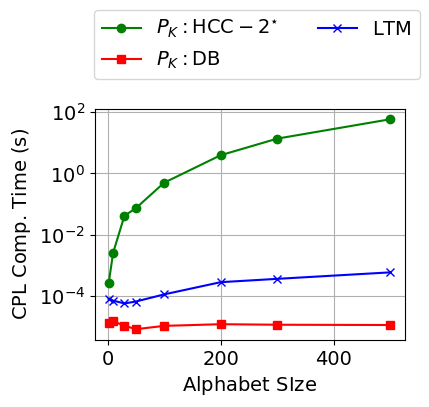

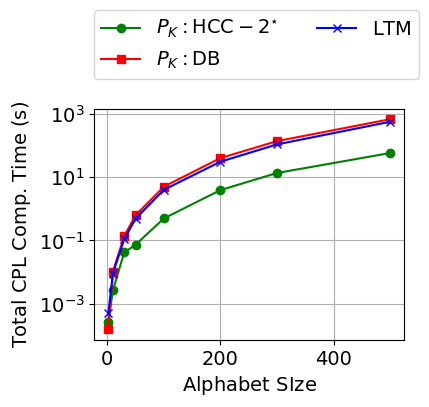

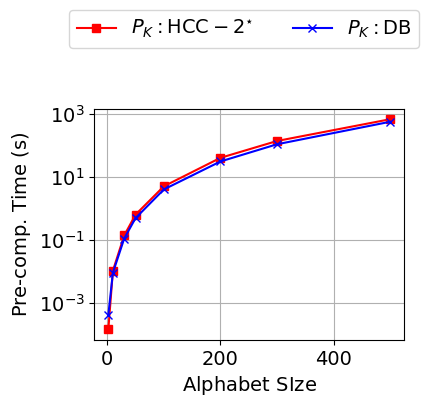

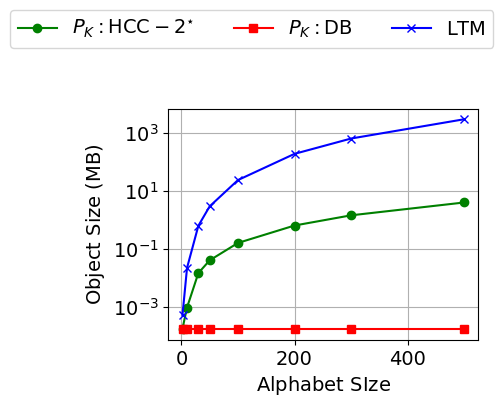

In [4]:
import matplotlib.pyplot as plt

pre_time_array = np.array(pre_time_list)
process_time_array = np.array(process_time_list)
space_array = np.array(space_list)

plt.figure(figsize=(4,3))
plt.plot(ALPHBET_SIZES, process_time_array[:,0], '-og')
plt.plot(ALPHBET_SIZES, process_time_array[:,1], '-rs')
plt.plot(ALPHBET_SIZES, process_time_array[:,2], '-bx')
plt.xlabel(r"$\text{Alphabet SIze}$", fontsize=14)
plt.ylabel(r"$\text{CPL Comp. Time (s)}$", fontsize=14)
plt.tick_params(axis='x', labelsize=14) 
plt.tick_params(axis='y', labelsize=14) 
plt.legend([ r"$P_K:\operatorname{HCC-2}^\star$", r"$P_K:\operatorname{DB}$", r"$\text{LTM}$"], fontsize=14, bbox_to_anchor=(1.08, 1.47), ncol=2)
ax = plt.grid(True)
plt.yscale('log')
plt.show()

plt.figure(figsize=(4,3))
plt.plot(ALPHBET_SIZES, process_time_array[:,0], '-og')
plt.plot(ALPHBET_SIZES, process_time_array[:,1] + pre_time_array[:,0], '-rs')
plt.plot(ALPHBET_SIZES, process_time_array[:,2] + pre_time_array[:,1], '-bx')
plt.xlabel(r"$\text{Alphabet SIze}$", fontsize=14)
plt.ylabel(r"$\text{Total CPL Comp. Time (s)}$", fontsize=14)
plt.tick_params(axis='x', labelsize=14)  
plt.tick_params(axis='y', labelsize=14)  
plt.legend([ r"$P_K:\operatorname{HCC-2}^\star$", r"$P_K:\operatorname{DB}$", r"$\text{LTM}$"], fontsize=14, bbox_to_anchor=(1.08, 1.47), ncol=2)
ax = plt.grid(True)
plt.yscale('log')
plt.show()

plt.figure(figsize=(4,3))
plt.plot(ALPHBET_SIZES, pre_time_array[:,0], '-rs')
plt.plot(ALPHBET_SIZES, pre_time_array[:,1], '-bx')
plt.xlabel(r"$\text{Alphabet SIze}$", fontsize=14)
plt.ylabel(r"$\text{Pre-comp. Time (s)}$", fontsize=14)
plt.tick_params(axis='x', labelsize=14) 
plt.tick_params(axis='y', labelsize=14) 
plt.legend([ r"$P_K:\operatorname{HCC-2}^\star$", r"$P_K:\operatorname{DB}$", r"$\text{LTM}$"], fontsize=14, bbox_to_anchor=(1.08, 1.47), ncol=2)
ax = plt.grid(True)
plt.yscale('log')
plt.show()

plt.figure(figsize=(4,3))
plt.plot(ALPHBET_SIZES, space_array[:,0], '-og')
plt.plot(ALPHBET_SIZES, space_array[:,1], '-rs')
plt.plot(ALPHBET_SIZES, space_array[:,2], '-bx')
plt.xlabel(r"$\text{Alphabet SIze}$", fontsize=14)
plt.ylabel(r"$\text{Object Size (MB)}$", fontsize=14)
plt.tick_params(axis='x', labelsize=14)  
plt.tick_params(axis='y', labelsize=14) 
plt.legend([ r"$P_K:\operatorname{HCC-2}^\star$", r"$P_K:\operatorname{DB}$", r"$\text{LTM}$"], fontsize=14, bbox_to_anchor=(1.08, 1.47), ncol=3)
ax = plt.grid(True)
plt.yscale('log')
plt.show()